# # Challenge FIAP 2024 | 1TSCPV-2024
## Grupo DataStorm
#### Ana Beatriz Azevedo RM 557420
#### Heloiza Oliveira RM 558881
#### Isabelle Nahas RM 557405
#### Matheus Madrid RM 555799
#### Sara Sitta RM 555113

# Neste passo, vamos aplicar o modelo selecionado (LGBM) ao nosso novo dataframe que traz os dados em "tempo real" de clima, e que será usada para fazer as predições de probabilidade de interrupção de energia.

# Bibliotecas, carregamento do modelo, importação dos dados de clima da API

In [ ]:
pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install lightgbm


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Importações de bibliotecas padrão do Python
import os
import random
import sys
import warnings

# Importações de bibliotecas de terceiros
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier


from sklearn.model_selection import train_test_split  # Para dividir os dados em treino e teste
from sklearn import metrics  # Para avaliar o modelo

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    pairwise_distances,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split


In [ ]:
RANDOM_STATE = 42

In [ ]:
df = pd.read_csv('C:/Users/anabe/Documents/FIAP/Challenge/Arquitetura Final/REFINED/DF_REFINED.csv')


In [ ]:
# Garantir a coversão da coluna de data
# Depois confirmar se coluna data foi convertida corretamente
df['DATA'] = pd.to_datetime(df['DATA'], errors='coerce')
df['DATA'] = df['DATA'].dt.strftime('%Y-%m-%d')
df['DATA']
df['DATA'] = pd.to_datetime(df['DATA'], errors='coerce')
if pd.api.types.is_datetime64_any_dtype(df['DATA']):
    print("A coluna está no formato datetime.")
else:
    print("A coluna não está no formato datetime.")
df['DATA']

A coluna está no formato datetime.


0       2022-01-01
1       2022-01-09
2       2022-01-11
3       2022-01-13
4       2022-01-16
           ...    
55955   2024-03-09
55956   2024-03-09
55957   2024-03-09
55958   2024-03-09
55959   2024-03-09
Name: DATA, Length: 55960, dtype: datetime64[ns]

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

def plot_roc_and_confusion(y_true, y_pred, y_pred_proba, model):
    # Cálculo da curva ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)

    # Plot da curva ROC
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', lw=2, label='Área sob a ROC = {:.2f}'.format(auc))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')

    # Cálculo e plot da matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    plt.subplot(1, 2, 2)
    disp.plot(ax=plt.gca())
    plt.title('Matriz de Confusão')

    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.metrics import classification_report

def display_classification_report(y_true, y_pred, model):
    # Gerar o relatório de classificação
    report = classification_report(y_true, y_pred)
    print("Relatório de Classificação:")
    print(report)


In [ ]:
import matplotlib.pyplot as plt

def plot_feature_importance(model, features):
    # Obtendo a importância das características
    importances = model.feature_importances_

    # Criando um DataFrame para facilitar a visualização
    feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})

    # Classificando as importâncias
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    # Plotando as importâncias
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
    plt.xlabel('Importância')
    plt.title('Importância das Características')
    plt.gca().invert_yaxis()  # Inverte o eixo y para mostrar a característica mais importante em cima
    plt.show()


In [ ]:

from sklearn.metrics import classification_report, confusion_matrix

# Definindo as variáveis de entrada (X) e a variável alvo (y)
X = df[['Tem Max', 'Tem Min', 'UR', 'IndiceDePluviometria']]
y = df['INTERRUPCOES']

# Dividindo em conjuntos de treino e teste, estratificando pela variável de subprefeitura
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df['SUB'], test_size=0.2, random_state=42)


2º Modelo LGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


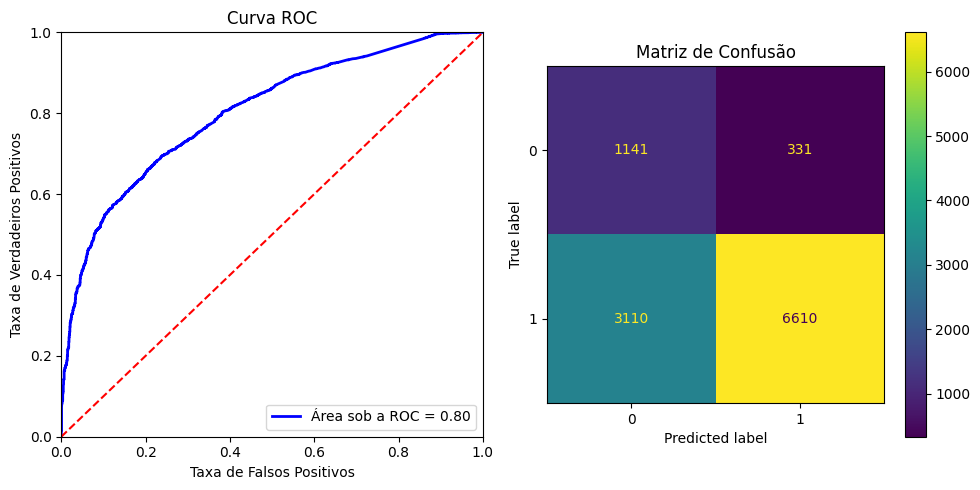

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.27      0.78      0.40      1472
           1       0.95      0.68      0.79      9720

    accuracy                           0.69     11192
   macro avg       0.61      0.73      0.60     11192
weighted avg       0.86      0.69      0.74     11192



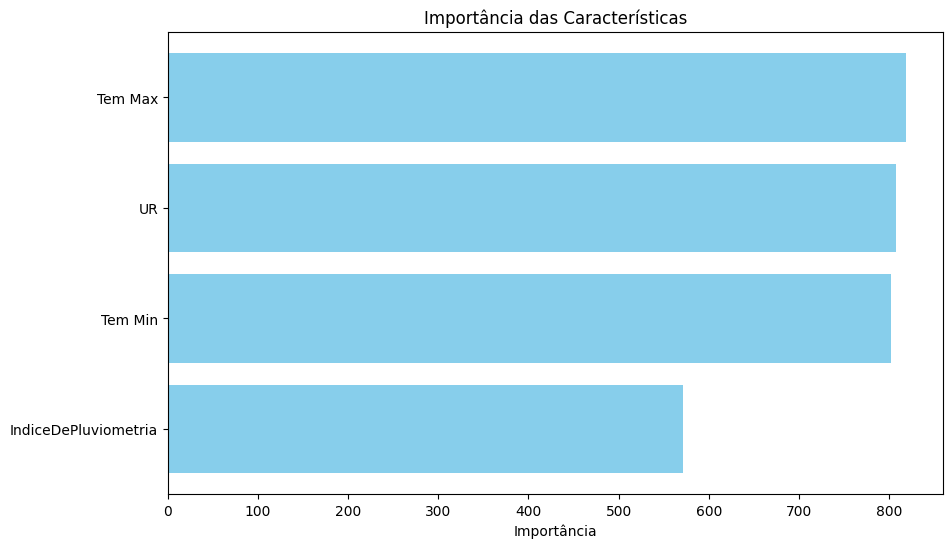

In [ ]:
# Treinando o Modelo LGBM
model_lgb = LGBMClassifier(
    class_weight='balanced',
    random_state=RANDOM_STATE,
    verbosity=0)  # `class_weight='balanced'` lida com desbalanceamento

model_lgb.fit(X_train, y_train)
# Avaliação do Modelo
y_pred_lgb = model_lgb.predict(X_test)
y_pred_proba_lgb = model_lgb.predict_proba(X_test)[:, 1]
threshold = 0.5  # Ajuste o threshold para algo mais moderado
y_pred_adjusted_lgb = (y_pred_proba_lgb >= threshold).astype(int)
# Executar as funções com os dados do modelo
plot_roc_and_confusion(y_test, y_pred_lgb, y_pred_proba_lgb, model_lgb)
display_classification_report(y_test, y_pred_lgb, model_lgb)
plot_feature_importance(model_lgb, X_train.columns)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

model_lgb = LGBMClassifier(
    class_weight='balanced',
    random_state=RANDOM_STATE,
    verbosity=0)  # `class_weight='balanced'` lida com desbalanceamento


# Definindo a grade de hiperparâmetros
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],

}

# Configurando o GridSearchCV
grid_search = GridSearchCV(estimator=model_lgb,
                           param_grid=param_grid,
                           scoring='f1_macro',  # Métrica para avaliação
                           cv=3,  # Validação Cruzada com 3 folds
                           verbose=1,
                           n_jobs=-1)  # Usar todos os processadores

# Executar o GridSearchCV
grid_search.fit(X_train, y_train)

# Melhor combinação de hiperparâmetros
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)

# Melhor estimador
best_model_lgb = grid_search.best_estimator_

# Fazendo previsões com o melhor modelo
y_pred_lgb_best = best_model_lgb.predict(X_test)

# Imprimindo o relatório
print("Relatório de Classificação para o melhor modelo LGB:")
print(classification_report(y_test, y_pred_lgb_best))


Fitting 3 folds for each of 120 candidates, totalling 360 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

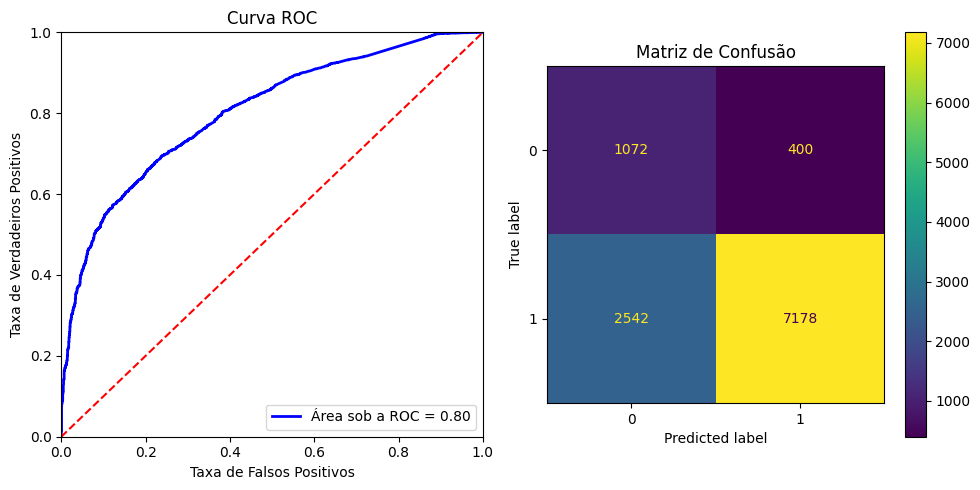

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.30      0.73      0.42      1472
           1       0.95      0.74      0.83      9720

    accuracy                           0.74     11192
   macro avg       0.62      0.73      0.63     11192
weighted avg       0.86      0.74      0.78     11192



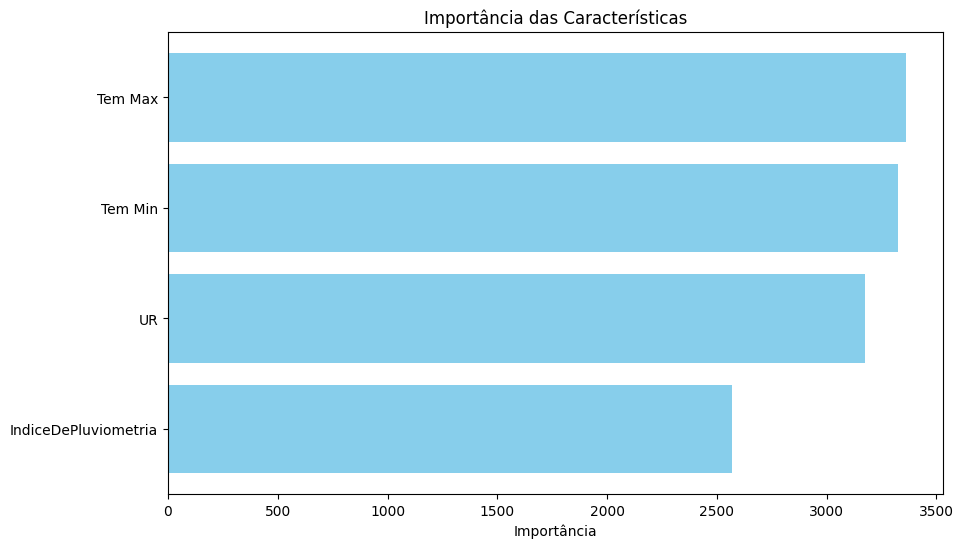

In [ ]:
# Executar as funções com os dados do modelo
plot_roc_and_confusion(y_test, y_pred_lgb_best, y_pred_proba_lgb, best_model_lgb)
display_classification_report(y_test, y_pred_lgb_best, best_model_lgb)
plot_feature_importance(best_model_lgb, X_train.columns)

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df_merged_mock = pd.read_csv('C:/Users/anabe/Documents/FIAP/Challenge/Arquitetura Final/TRUSTED/df_merged_mock.csv', sep=';')


In [ ]:
df_merged_mock.head()

,Unnamed: 0,SUB,DATA,IndiceDePluviometria,Tem Max,Tem Min,UR
0,0,AD,01/01/2022,5.5,28.9,17.9,54.9
1,1,AD,02/01/2022,0.7,32.3,19.9,42.7
2,2,AD,03/01/2022,3.0,32.1,20.7,47.1
3,3,AD,04/01/2022,8.4,28.9,20.8,58.4
4,4,AD,05/01/2022,16.5,28.7,20.3,60.2


# Aplicação do modelo aos dados de previsão do tempo para cada Subprefeitura
### Para termos uma massa de dados maior dentro do Dashboard, mockamos dados históricos dos últimos dois meses, silumando um histórico de previsões

In [ ]:
import pandas as pd
import numpy as np


# Obtém lista única de subprefeituras do conjunto de dados original
subprefeituras = df_merged_mock['SUB'].unique()

# Data de início e intervalo de tempo
start_date = '2024-07-01'
date_range = pd.date_range(start=start_date, periods=99)  # Gerando 99 dias

# Criar lista para guardar os dados mockados
mocked_data = []

# Gerar dados para cada subprefeitura
for sub in subprefeituras:
    for date in date_range:
        mocked_data.append({
            'SUB': sub,
            'DATA': date,
            'Tem Max': np.random.uniform(20, 30),  # Temperaturas entre 25 e 35 graus
            'Tem Min': np.random.uniform(6, 20),  # Temperaturas entre 15 e 25 graus
            'UR': np.random.uniform(30, 70),      # Umidade relativa entre 40% e 100%
            'IndiceDePluviometria': np.random.uniform(0, 8),  # Índice de pluviometria entre 0 e 40
        })

# Cria o DataFrame com os dados mockados
df_merged_mock = pd.DataFrame(mocked_data)

# Exibindo o DataFrame mockado
print(df_merged_mock)


     SUB       DATA    Tem Max    Tem Min         UR  IndiceDePluviometria
0     AD 2024-07-01  23.897546  17.594476  67.767579              5.267379
1     AD 2024-07-02  21.700651  14.903345  31.417185              6.608759
2     AD 2024-07-03  26.208327  10.720294  44.756212              2.457667
3     AD 2024-07-04  21.565068   7.586559  63.806607              5.776434
4     AD 2024-07-05  25.377750  14.422751  38.379632              3.414080
...   ..        ...        ...        ...        ...                   ...
1876  VP 2024-10-03  22.881107  18.289865  61.916938              5.572554
1877  VP 2024-10-04  20.769052  14.435523  35.308344              2.601406
1878  VP 2024-10-05  24.504576  19.443741  36.254670              1.376801
1879  VP 2024-10-06  21.787337   6.899259  38.962399              7.463877
1880  VP 2024-10-07  24.285213  15.516378  56.213121              6.315696

[1881 rows x 6 columns]


In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier


# Criar um DataFrame vazio para armazenar todas as predições
all_predictions = pd.DataFrame()

# Loop sobre cada subprefeitura
for sub, group in df_merged_mock.groupby('SUB'):
    # Prepara o conjunto de dados do grupo atual para previsão
    X_mocked = group[['Tem Max', 'Tem Min', 'UR', 'IndiceDePluviometria']]

    # Executa a predição das probabilidades
    probabilities = best_model_lgb.predict_proba(X_mocked)

    # Seleciona a probabilidade da classe positiva (e.g., 1)
    group['Probability_Class_1'] = probabilities[:, 1]

    # Anexa ao DataFrame total
    all_predictions = pd.concat([all_predictions, group], ignore_index=True)

# Exibe o DataFrame completo com as probabilidades
print(all_predictions)


     SUB       DATA    Tem Max    Tem Min         UR  IndiceDePluviometria  \
0     AD 2024-07-01  23.897546  17.594476  67.767579              5.267379   
1     AD 2024-07-02  21.700651  14.903345  31.417185              6.608759   
2     AD 2024-07-03  26.208327  10.720294  44.756212              2.457667   
3     AD 2024-07-04  21.565068   7.586559  63.806607              5.776434   
4     AD 2024-07-05  25.377750  14.422751  38.379632              3.414080   
...   ..        ...        ...        ...        ...                   ...   
1876  VP 2024-10-03  22.881107  18.289865  61.916938              5.572554   
1877  VP 2024-10-04  20.769052  14.435523  35.308344              2.601406   
1878  VP 2024-10-05  24.504576  19.443741  36.254670              1.376801   
1879  VP 2024-10-06  21.787337   6.899259  38.962399              7.463877   
1880  VP 2024-10-07  24.285213  15.516378  56.213121              6.315696   

      Probability_Class_1  
0                0.668830  
1      

In [ ]:
all_predictions

,SUB,DATA,Tem Max,Tem Min,UR,IndiceDePluviometria,Probability_Class_1
0,AD,2024-07-01,23.897546,17.594476,67.767579,5.267379,0.668830
1,AD,2024-07-02,21.700651,14.903345,31.417185,6.608759,0.947757
2,AD,2024-07-03,26.208327,10.720294,44.756212,2.457667,0.744570
3,AD,2024-07-04,21.565068,7.586559,63.806607,5.776434,0.998751
4,AD,2024-07-05,25.377750,14.422751,38.379632,3.414080,0.323237
...,...,...,...,...,...,...,...
1876,VP,2024-10-03,22.881107,18.289865,61.916938,5.572554,0.488456
1877,VP,2024-10-04,20.769052,14.435523,35.308344,2.601406,0.637065
1878,VP,2024-10-05,24.504576,19.443741,36.254670,1.376801,0.708479
1879,VP,2024-10-06,21.787337,6.899259,38.962399,7.463877,0.999131


In [ ]:
all_predictions.to_csv('all_predictions.csv', index=False)
